# Frequent Directions
We look at the implementation from [deterministic ridge regression](https://arxiv.org/pdf/2002.02013.pdf)

In [696]:
import numpy as np
from numpy.linalg import svd, inv, pinv
from sklearn.linear_model import Ridge
from scipy import linalg
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.append('..')
from data_factory import DataFactory
from math import floor
from utils import sparse_projection
np.set_printoptions(precision=4)
%config Completer.use_jedi = False

In [376]:
n = 2**10
d=2**8
eff_rank = int(floor(0.25*d + 0.5))
ds = DataFactory(n=n,d=d,effective_rank=eff_rank)
X,y,w0 = ds.shi_phillips_synthetic()
X /= np.linalg.norm(X,ord='fro')

In [377]:
class FD():

    def __init__(self, d, ell=8):
        self.d = d
        self.reset(ell=ell)

    def reset(self, ell=None):
        if ell is not None:
            self.ell = ell
        self.X = np.zeros((self.ell, self.d))
        self.Vt = np.zeros((self.ell, self.d))
        self.s2 = np.zeros(self.ell)  # Sigma^2

    def feed(self, X):
        self.X = np.concatenate((self.X, X), axis=0)
        # TODO: try sklearn.decomposition.TruncatedSVD
        try:
            _, s, self.Vt = svd(self.X, full_matrices=False)
        except np.linalg.LinAlgError:
            np.save(f'./np_svd_fail{datetime.datetime.now().strftime("%I:%M%p on %B %d, %Y")}.npy', self.X)
            _, s, self.Vt = linalg.svd(self.X, full_matrices=False, lapack_driver='gesvd')
        self.s2 = s**2  # Sigma^2
        self._shrink()  # shrink self.s2 and self.Vt
        self.X = self.Vt * np.sqrt(self.s2).reshape(-1, 1)
        return self

    def result(self):
        return self.X, self.s2, self.Vt
    
class FFD(FD):

    def _shrink(self):
        self.s2 = self.s2[:self.ell] - self.s2[self.ell]
        self.Vt = self.Vt[:self.ell]


In [378]:
sketcher = FFD(d,ell=16)
sketcher.feed(X)
B, s2, vt = sketcher.result()

In [379]:
B.shape

(16, 256)

In [380]:
cov = X.T@X
cov_est = B.T@B
err = np.linalg.norm(cov - cov_est,ord=2)
print(err)

0.02571931772963339


In [381]:
sketch_dimensions = np.array([8,16,32,64,128])
errors = np.zeros_like(sketch_dimensions,dtype=float)
error_bound = np.zeros_like(sketch_dimensions,dtype=float)
covariance = X.T@X
frob_norm = np.linalg.norm(X,ord='fro')**2
U,S,Vt = np.linalg.svd(X,full_matrices=False)
for i, si in enumerate(sketch_dimensions):
    #print(f'Testing dimenion {si}')
    sketcher = FFD(d,ell=si)
    sketcher.feed(X)
    B, s2, vt = sketcher.result()
    
    # Error bound wrt to k
    k = 0#si - 1
    Ak = U[:,:k]@(np.diag(S[:k])@Vt[:k,:])
    error_norm = np.linalg.norm(X - Ak,ord='fro')**2
    cov_error = np.linalg.norm(B.T@B - covariance,ord=2)
    errors[i] = cov_error/error_norm
    error_bound[i] = 1./(si - k)
    
    print(f'Dimension:{si}\tError:{cov_error:.4f}\tError norm:{error_norm:.4f}')

Dimension:8	Error:0.0331	Error norm:1.0000
Dimension:16	Error:0.0257	Error norm:1.0000
Dimension:32	Error:0.0118	Error norm:1.0000
Dimension:64	Error:0.0006	Error norm:1.0000
Dimension:128	Error:0.0000	Error norm:1.0000


Text(0, 0.5, '$||A^TA - B^TB||_F^2 / ||A^TA||_F^2$')

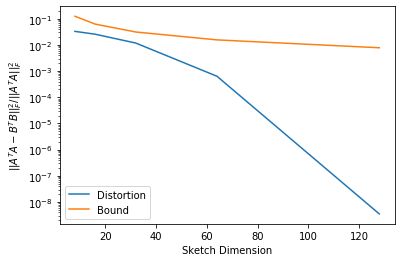

In [382]:
fig,ax = plt.subplots()
ax.plot(sketch_dimensions, errors,label='Distortion')
#ax.plot(sketch_dimensions, 1./sketch_dimensions,label='Bound')
ax.plot(sketch_dimensions, error_bound,label='Bound')
ax.legend()
ax.set_yscale('log')
ax.set_xlabel('Sketch Dimension')
ax.set_ylabel('$||A^TA - B^TB||_F^2 / ||A^TA||_F^2$')

In [383]:
errors

array([3.3053e-02, 2.5719e-02, 1.1821e-02, 6.3816e-04, 3.5181e-09])

In [384]:
class myFD:
    def __init__(self,d,m=8):
        '''
        Class wrapper for all FD-type methods
        '''
        self.d = d
        self.reset(sketch_dim=m)
        self.delta = 0. # For RFD
        
    def reset(self,sketch_dim=None):
        '''
        Initialises or resets the sketch parameters
        '''
        if sketch_dim is not None:
            self.sketch_dim = sketch_dim
        self.sketch = np.zeros((self.sketch_dim,self.d),dtype=float)
        self.Vt = np.zeros((self.sketch_dim,self.d),dtype=float)
        self.S2 = np.zeros(self.sketch_dim,dtype=float) # singular values squared
        
    def fit(self,X,batch_size=1):
        '''
        Fits the FD transform to dataset X
        '''
        #self.sketch = np.concatenate()
        n = X.shape[0]
        count = 0
        extra_space = np.zeros_like(self.sketch)
        head = 0
        tail = batch_size
        for i in range(0,n,batch_size):
            batch = X[i:i+batch_size,:]
            aux = np.concatenate((self.sketch,batch),axis=0)
            #print(f'Start:{i}\tStop{i+batch_size}')
            #print(batch.shape)
            try:
                _, s, self.Vt = svd(aux, full_matrices=False)
            except np.linalg.LinAlgError:
                np.save(f'./np_svd_fail{datetime.datetime.now().strftime("%I:%M%p on %B %d, %Y")}.npy', aux)
                _, s, self.Vt = linalg.svd(aux, full_matrices=False, lapack_driver='gesvd')
            self.S2 = s**2 
            self._shrink()  # shrink self.s2 and self.Vt
            self.sketch = self.Vt * np.sqrt(self.S2).reshape(-1, 1)
        
    def get(self):
        return self.sketch, self.S2, self.Vt
        
            
class FastFrequentDirections(myFD):
    '''
    Implements the fast version of FD by doubling space
    '''
    
    def _shrink(self):
        self.S2 = self.S2[:self.sketch_dim] - self.S2[self.sketch_dim]
        self.Vt = self.Vt[:self.sketch_dim]
        
class iSVD(myFD):
    '''
    Implements the ***heuristic*** incremental SVD
    '''
    
    def _shrink(self):
        self.S2 = self.S2[:self.sketch_dim]
        self.Vt = self.Vt[:self.sketch_dim]
        
class RFD(myFD):
    '''
    Implements the RFD version of FD 
    '''
    
    def _shrink(self):
        self.delta += self.S2[self.sketch_dim]/2.
        self.S2 = self.S2[:self.sketch_dim] - self.S2[self.sketch_dim]
        self.Vt = self.Vt[:self.sketch_dim]

In [385]:
batch_size = 32
my_fd = FastFrequentDirections(X.shape[1],m=batch_size)
my_fd.fit(X,batch_size=batch_size)

In [386]:
my_fd.sketch.shape

(32, 256)

In [387]:
my_fd.sketch

array([[ 0.0292,  0.0291,  0.0289, ..., -0.0057, -0.0039, -0.002 ],
       [-0.0154, -0.0151, -0.0142, ..., -0.0038, -0.0025, -0.0013],
       [-0.0125, -0.0121, -0.011 , ...,  0.0042,  0.0028,  0.0014],
       ...,
       [-0.0008, -0.0008, -0.0009, ..., -0.0017, -0.0014, -0.0008],
       [ 0.0024,  0.0022,  0.0014, ...,  0.0009,  0.0007,  0.0004],
       [ 0.0004,  0.0003,  0.0002, ..., -0.0004, -0.0003, -0.0001]])

In [388]:
B = my_fd.sketch

In [389]:
np.linalg.norm(B.T@B - X.T@X,ord=2)/np.linalg.norm(X,ord='fro')**2

0.016896277316357212

In [390]:
sketch_dimensions = np.array([16,32,64,128,200])
error_bound = np.zeros_like(sketch_dimensions,dtype=float)
fd_error_bound = np.zeros_like(sketch_dimensions,dtype=float)
rfd_error_bound = np.zeros_like(sketch_dimensions,dtype=float)
isvd_error_bound = np.zeros_like(sketch_dimensions,dtype=float)

covariance = X.T@X
frob_norm = np.linalg.norm(X,ord='fro')**2
U,S,Vt = np.linalg.svd(X,full_matrices=False)
for i, si in enumerate(sketch_dimensions):
    # Error bound wrt to k
    k = 2
    Ak = U[:,:k]@(np.diag(S[:k])@Vt[:k,:])
    error_norm = np.linalg.norm(X - Ak,ord='fro')**2
    print(f'Dimension:{si}\tError norm:{error_norm:.4f}')
    error_bound[i] = 1./(si - k)
    
    # FFD
    sketcher = FastFrequentDirections(X.shape[1],m=si)
    sketcher.fit(X,batch_size=si)
    B = sketcher.sketch
    fd_cov_error = np.linalg.norm(B.T@B - covariance,ord=2)
    
    # RFD
    rfd_sketcher = RFD(X.shape[1],m=si)
    rfd_sketcher.fit(X,batch_size=si)
    rB = rfd_sketcher.sketch
    rfd_cov_error = np.linalg.norm(rB.T@rB - covariance,ord=2)
    
    # iSVD
    isvd_sketcher = iSVD(X.shape[1],m=si)
    isvd_sketcher.fit(X,batch_size=si)
    iB = isvd_sketcher.sketch
    isvd_cov_error = np.linalg.norm(iB.T@iB - covariance,ord=2)
    

    
    fd_error_bound[i] = fd_cov_error/error_norm
    rfd_error_bound[i] = rfd_cov_error/error_norm
    isvd_error_bound[i] = isvd_cov_error/error_norm

    print(f'FD:{(fd_cov_error/error_norm):.4f}\tRFD:{(rfd_cov_error/error_norm):.4f}\tiSVD:{(isvd_cov_error/error_norm):.4f}')

Dimension:16	Error norm:0.9179
FD:0.0415	RFD:0.0415	iSVD:0.0335
Dimension:32	Error norm:0.9179
FD:0.0184	RFD:0.0184	iSVD:0.0162
Dimension:64	Error norm:0.9179
FD:0.0008	RFD:0.0008	iSVD:0.0007
Dimension:128	Error norm:0.9179
FD:0.0000	RFD:0.0000	iSVD:0.0000
Dimension:200	Error norm:0.9179
FD:0.0000	RFD:0.0000	iSVD:0.0000


Text(0, 0.5, '$||A^TA - B^TB||_F^2 / ||A^TA||_F^2$')

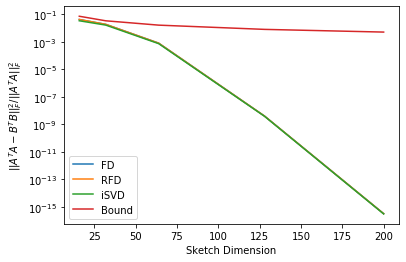

In [391]:
fig,ax = plt.subplots()
ax.plot(sketch_dimensions, fd_error_bound,label='FD')
ax.plot(sketch_dimensions, rfd_error_bound,label='RFD')
ax.plot(sketch_dimensions, isvd_error_bound,label='iSVD')
#ax.plot(sketch_dimensions, 1./sketch_dimensions,label='Bound')
ax.plot(sketch_dimensions, error_bound,label='Bound')
ax.legend()
ax.set_yscale('log')
ax.set_xlabel('Sketch Dimension')
ax.set_ylabel('$||A^TA - B^TB||_F^2 / ||A^TA||_F^2$')

In [392]:
np.c_[fd_error_bound,rfd_error_bound,isvd_error_bound]

array([[4.1506e-02, 4.1506e-02, 3.3484e-02],
       [1.8408e-02, 1.8408e-02, 1.6244e-02],
       [7.9283e-04, 7.9283e-04, 7.2864e-04],
       [3.9977e-09, 3.9977e-09, 3.8528e-09],
       [3.2649e-16, 3.2649e-16, 3.1265e-16]])

### Ridge Regression
Now that we have the sketch working well we want to use it for regression.

In [393]:
class FDRidge:
    
    def __init__(self, fd_dim:int,fd_mode='FD',gamma=1.0):
        """
        Approximate ridge regression using the FD sketch.

        fd_dim (int) - the number of rows retained in the FD sketch.
        fd_mode (str) : mode for frequent directions FD or RFD.
        alpha : float - the regularisation parameter for ridge regression.
        """
        self.fd_dim       = fd_dim
        self.fd_mode      = fd_mode
        self.gamma        = gamma
        self.is_fitted    = False

    def fit(self,X,y):
        '''
        Fits the ridge regression model on data X with targets y
        '''
        d = X.shape[1]
        # 1. Sketch the data
        sketcher = FastFrequentDirections(X.shape[1],m=self.fd_dim)
        sketcher.fit(X,batch_size=self.fd_dim)
        B = sketcher.sketch
        H = B.T@B + self.gamma*np.eye(d)
        self.coef_ = np.linalg.solve(H, X.T@y)
        
    def iterate(self,X,y,iterations=10):
        '''
        Fits the iterated ridge model with FD
        '''
        d = X.shape[1]
        w = np.zeros((d,1),dtype=float)
        all_w = np.zeros((d,iterations))
        XTy = (X.T@y).reshape(-1,1)
        
        # Fit the FD
        sketcher = FastFrequentDirections(X.shape[1],m=self.fd_dim)
        sketcher.fit(X,batch_size=self.fd_dim)
        B = sketcher.sketch
        H = B.T@B + self.gamma*np.eye(d)
        H_inv = np.linalg.pinv(H)
        for it in range(iterations):
            grad = X.T@(X@w) + self.gamma*w - XTy
            w += - H_inv@grad
            all_w[:,it] = np.squeeze(w)
        return np.squeeze(w), all_w
    
    def get_bias(self,X,w0):
        '''
        Returns the bias of the estimate
        '''
        sketcher = FastFrequentDirections(X.shape[1],m=self.fd_dim)
        sketcher.fit(X,batch_size=self.fd_dim)
        B = sketcher.sketch
        H = B.T@B + self.gamma*np.eye(d)
        return np.linalg.pinv(H)@(X.T@(X@w0)) - w0
    
        

In [394]:
gamma = 1024
fdr = FDRidge(fd_dim=64,gamma=gamma)
fdr.fit(X,y)
x_fd = fdr.coef_

In [396]:
H = X.T@X + gamma*np.eye(d)
x_opt = np.linalg.solve(H,X.T@y)

clf = Ridge(alpha=gamma,fit_intercept=False)
clf.fit(X,y)
x_skl = clf.coef_
print(np.linalg.norm(x_skl - x_opt))

2.6059045479598724e-17


In [397]:
#np.c_[x_skl,x_opt,x_fd]

In [398]:
np.linalg.norm(x_opt - x_fd)/np.linalg.norm(x_opt)

7.104752802784134e-07

In [399]:
fdr = FDRidge(fd_dim=88,gamma=gamma)
fdr.fit(X,y)
x_ihs_fd, all_x = fdr.iterate(X,y,10)
x_fd = fdr.coef_

In [400]:
np.linalg.norm(x_ihs_fd - x_opt)

1.897345472152122e-17

In [401]:
ihs_fd_errors = [np.linalg.norm(all_x[:,_] - x_opt)/np.linalg.norm(x_opt) for _ in range(all_x.shape[1])]

In [402]:
ihs_fd_errors

[1.8040869296048362e-08,
 6.529954403275437e-16,
 6.15698643135539e-16,
 6.15698643135539e-16,
 6.15698643135539e-16,
 6.15698643135539e-16,
 6.15698643135539e-16,
 6.15698643135539e-16,
 6.15698643135539e-16,
 6.15698643135539e-16]

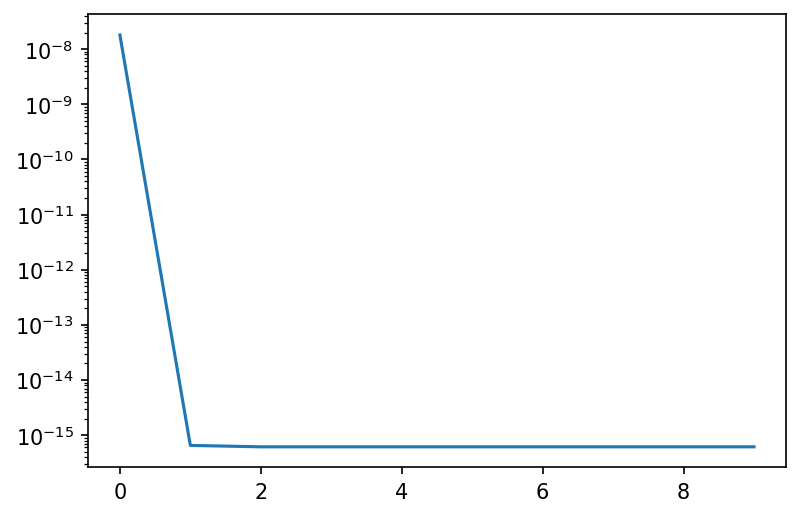

In [403]:
fig,ax = plt.subplots(dpi=150)
ax.plot(ihs_fd_errors)
ax.set_yscale('log')

## Bias variance tradeoff

In [680]:
n = 2**10
d=2**8
eff_rank = int(floor(0.25*d + 0.5))
ds = DataFactory(n=n,d=d,effective_rank=eff_rank)
X,y,w0 = ds.shi_phillips_synthetic()
X /= np.linalg.norm(X,ord='fro')

In [723]:
gamma = 512.
H = X.T@X + gamma*np.eye(d)
x_opt = np.linalg.solve(H,X.T@y)
opt_bias = (gamma**2)*np.linalg.norm(np.linalg.pinv(H)@w0)**2

In [724]:
opt_bias

0.9999733854701851

In [725]:
fdr = FDRidge(fd_dim=150,gamma=gamma)
fdr.fit(X,y)
x_ihs_fd, all_x = fdr.iterate(X,y,10)
x_fd = fdr.coef_
fd_bias = fdr.get_bias(X,w0)

In [726]:
fd_bias_sq = np.linalg.norm(fd_bias)**2
print('FD bias:',fd_bias_sq)
print('Error to opt: ', np.linalg.norm(x_fd-x_opt)/np.linalg.norm(x_opt))

FD bias: 0.9999733854701858
Error to opt:  1.6544498977470353e-14


We selected parameters $\gamma = 1024$ and $m=150$. This yields $c = 1 - \frac{1}{\gamma m}$

In [685]:
mm = 150
c = 1. - 1./(gamma*mm)
print('c = ', c)

c =  0.5733333333333333


In [686]:
upper_bound = (1./c**2)*opt_bias
lower_bound = (c**2)*opt_bias
print(f'Lower:{lower_bound:.10f}\tFD:{fd_bias_sq:.10f}\t\tUpper:{upper_bound:.10f}')
assert lower_bound < fd_bias_sq
assert upper_bound > fd_bias_sq

Lower:0.2520746674	FD:0.7668577632		Upper:2.3329231574


In [694]:
mm = 64#fdr.sketch.shape[0]
all_gammas = np.array([2**_ for _ in [-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6]])
H = X.T@X
opt_bias = np.zeros_like(all_gammas,dtype=float)
lower_bound = np.zeros_like(opt_bias)
upper_bound = np.zeros_like(opt_bias)
fd_bias_vals = np.zeros_like(opt_bias)
for i,g in enumerate(all_gammas):
    Hg = H + g*np.eye(d)
    x_opt = np.linalg.solve(Hg,X.T@y)
    bias_g = (g**2)*np.linalg.norm(np.linalg.pinv(Hg)@w0)**2 #np.linalg.norm(x_opt - w0)**2 #
    #print(bias_g)
    
    # Sketch
    fdr = FDRidge(fd_dim=mm,gamma=g)
    fdr.fit(X,y)
    fd_bias = fdr.get_bias(X,w0) 
    err2opt = np.linalg.norm(fdr.coef_ - x_opt)/np.linalg.norm(x_opt)
    fd_bias_sq = np.linalg.norm(fd_bias)**2 #np.linalg.norm(fdr.coef_ - w0)**2 #
    
    # Bounds 
    c = 1. - 1./(g*mm)
    if c < 0:
        continue
    upper = (1./c**2)*bias_g
    lower = (c**2)*bias_g
    opt_bias[i] = bias_g
    lower_bound[i] = lower 
    upper_bound[i] = upper
    fd_bias_vals[i] = fd_bias_sq
    print(f'γ:{g:.5f}  c:{c:.5f}\tOPT:{bias_g:.5f}  Lower:{lower:.5f}  Upper:{upper:.5f}  FD:{fd_bias_sq:.5f} SE:{err2opt:.5f}')
    if (fd_bias_sq < lower) or (fd_bias_sq > upper):
        print('⚠️ - BOUND NOT MET 🚫 ')

/Users/charlied/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in double_scalars


γ:0.01562  c:0.00000	OPT:0.76686  Lower:0.00000  Upper:inf  FD:0.76368 SE:0.01782
γ:0.03125  c:0.50000	OPT:0.81898  Lower:0.20474  Upper:3.27591  FD:0.81722 SE:0.01192
γ:0.06250  c:0.75000	OPT:0.87280  Lower:0.49095  Upper:1.55165  FD:0.87196 SE:0.00761
γ:0.12500  c:0.87500	OPT:0.91980  Lower:0.70422  Upper:1.20137  FD:0.91946 SE:0.00451
γ:0.25000  c:0.93750	OPT:0.95381  Lower:0.83831  Upper:1.08522  FD:0.95370 SE:0.00251
γ:0.50000  c:0.96875	OPT:0.97500  Lower:0.91501  Upper:1.03892  FD:0.97497 SE:0.00133
γ:1.00000  c:0.98438	OPT:0.98696  Lower:0.95636  Upper:1.01854  FD:0.98695 SE:0.00069
γ:2.00000  c:0.99219	OPT:0.99334  Lower:0.97788  Upper:1.00904  FD:0.99333 SE:0.00035
γ:4.00000  c:0.99609	OPT:0.99663  Lower:0.98886  Upper:1.00446  FD:0.99663 SE:0.00018
γ:8.00000  c:0.99805	OPT:0.99831  Lower:0.99441  Upper:1.00222  FD:0.99831 SE:0.00009
γ:16.00000  c:0.99902	OPT:0.99915  Lower:0.99720  Upper:1.00110  FD:0.99915 SE:0.00004
γ:32.00000  c:0.99951	OPT:0.99957  Lower:0.99860  Upper:1

Text(0, 0.5, 'Bias Squared')

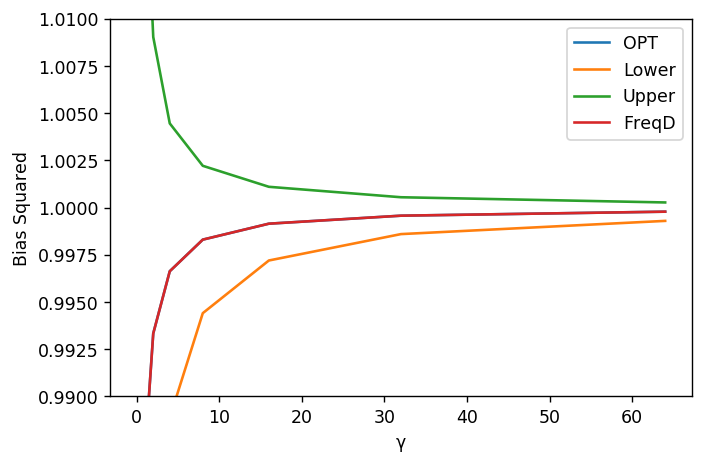

In [695]:
fig,ax = plt.subplots(dpi=125)
ax.plot(all_gammas,opt_bias,label='OPT')
ax.plot(all_gammas,lower_bound, label='Lower')
ax.plot(all_gammas,upper_bound, label='Upper')
ax.plot(all_gammas,fd_bias_vals, label='FreqD')
ax.legend()
#ax.set_yscale('log')
ax.set_ylim(0.99,1.01)
# ax.set_xlim(-0.005,500)
ax.set_xlabel('γ')
ax.set_ylabel('Bias Squared')

Can we also plot the error compared to the true bias?

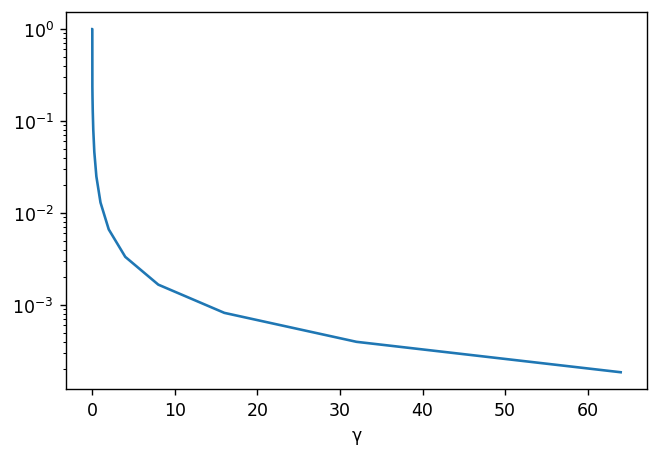

In [731]:
fig,ax = plt.subplots(dpi=125)
ax.plot(all_gammas,np.abs(opt_bias-fd_bias_vals)/opt_bias,label='Relative Error')
ax.set_xlabel('γ')
ax.set_yscale('log')
#ax.set_xscale('log')

## Comparison to Random projections.

Let's implement one-pass regression using random projections and compare the bias terms.

In [713]:
class RPRidge:
    def __init__(self,rp_dim:int,rp_mode='Sparse',gamma=1.0):
        self.rp_dim       = rp_dim
        self.rp_mode      = rp_mode
        self.gamma        = gamma
        self.is_fitted    = False

    def fit_classical(self,X,y):
        '''
        Fits the ridge regression model on data X with targets y
        '''
        d = X.shape[1]
        data = np.c_[X,y]
        S_data = sparse_projection(data,self.rp_dim,sparsity=1)
        SX = S_data[:,:-1]
        Sy = S_data[:,-1]
        H_est = SX.T@SX + self.gamma*np.eye(d)
        self.classical_coef_ = np.linalg.solve(H_est,SX.T@Sy)
        
    def fit_hessian_sketch(self,X,y):
        '''
        Fits the ridge regression model on data X with targets y
        '''
        d = X.shape[1]
        SX = sparse_projection(X,self.rp_dim,sparsity=1)
        H_est = SX.T@SX + self.gamma*np.eye(d)
        self.hessian_coef_ = np.linalg.solve(H_est,X.T@y)
        

In [714]:
gamma = 1024
H = X.T@X + gamma*np.eye(d)
x_opt = np.linalg.solve(H,X.T@y)
#opt_bias = (gamma**2)*np.linalg.norm(np.linalg.pinv(H)@w0)**2

In [715]:
rpr = RPRidge(rp_dim=150,gamma=1024)
rpr.fit_classical(X,y)
rpr.fit_hessian_sketch(X,y)
x_ss = rpr.classical_coef_
x_hs = rpr.hessian_coef_

In [711]:
np.linalg.norm(x_ss - x_opt)/np.linalg.norm(x_opt)

0.4549829252600121

In [716]:
np.linalg.norm(x_hs - x_opt)/np.linalg.norm(x_opt)

1.7008759164127884e-05

### To Do:
- Tidy this code and put into separate classes
- Refine the experimental section for both bias-variance and iterative method.